Test CosmiQNet

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import sys
sys.path.append("../common/")

import cv2
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from data_utils import TRAIN_IMAGE_IDS, LABELS, TRAIN_DATA, TRAIN_LABEL_TILES
from image_utils import get_image_data, get_image_tile_data, normalize
from visu_utils import display_img_1b, display_labels, plt_st

In [4]:
from glob import glob
all_train_ids = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_ids = np.array([s[len(TRAIN_DATA)+1:-4] for s in all_train_ids if 'mean' not in s and 'std' not in s])
print "First & last train ids : ", all_train_ids[0], all_train_ids[-1], len(all_train_ids)

First & last train ids :  6010_1_2 6170_4_1 25


In [5]:
from image_utils import imwrite, compute_mean_std_on_images
from geo_utils.GeoImage import GeoImage

np.random.shuffle(all_train_ids)
ll = int(len(all_train_ids)*0.8)
train_ids = all_train_ids[:ll]
val_ids = all_train_ids[ll:]


def compute_mean_std(image_type, feature_wise, out_shape):
    s = ''
    if feature_wise:
        s = "_feature_wise"
    
    mean_fname = os.path.join(TRAIN_DATA, 'mean_%s_image%s.tif' % (image_type, s))
    std_fname = os.path.join(TRAIN_DATA, 'std_%s_image%s.tif' %  (image_type, s))
    if not os.path.exists(mean_fname) or not os.path.exists(std_fname):
        logging.getLogger().setLevel(logging.INFO)
        mean_image, std_image = compute_mean_std_on_images(train_ids, image_type, feature_wise=feature_wise, out_shape=out_shape)
        logging.getLogger().setLevel(logging.ERROR)
        imwrite(mean_fname, mean_image)
        imwrite(std_fname, std_image)
    else:
        mean_image = GeoImage(mean_fname).get_data()
        std_image = GeoImage(std_fname).get_data()
    return mean_image, std_image




img_ms_shape = (860, 860, 8)
img_rgb_shape = (860*4, 860*4, 3)
feature_wise = True

mean_rgb_image, std_rgb_image = compute_mean_std('3b', feature_wise, img_rgb_shape)
mean_ms_image, std_ms_image = compute_mean_std('ms', feature_wise, img_ms_shape)
        
print "RGB"    
print mean_rgb_image.shape, std_rgb_image.shape
print mean_rgb_image.min(), mean_rgb_image.max(), std_rgb_image.min(), std_rgb_image.max()

print "MS" 
print mean_ms_image.shape, std_ms_image.shape
print mean_ms_image.min(), mean_ms_image.max(), std_ms_image.min(), std_ms_image.max()

print len(train_ids), len(val_ids)

logging.getLogger().setLevel(logging.ERROR)

RGB
(3440, 3440, 3) (3440, 3440, 3)
0.0 471.175 0.0 60.8137
MS
(860, 860, 8) (860, 860, 8)
0.0 708.458 0.0 83.604
20 5


In [6]:
from training_utils import normalize_image


def generate_images(image_ids_to_use, batch_size):
    while True:        
        X_rgb = np.zeros((batch_size, img_rgb_shape[2]) + img_rgb_shape[:2], dtype=np.float32)
        X_ms = np.zeros((batch_size, img_ms_shape[2]) + img_ms_shape[:2], dtype=np.float32)
        Y = np.zeros((batch_size, 1) + img_ms_shape[:2], dtype=np.float32)
        
        counter = 0
        for image_id in image_ids_to_use:     
            
            img_rgb = get_image_data(image_id, '3b')
            img_ms = get_image_data(image_id, 'ms')
            img_label = get_image_data(image_id, 'label')[:,:,labels]            
            img_label = cv2.resize(img_label, dsize=img_ms_shape[:2], interpolation=cv2.INTER_LINEAR)
            
            img_rgb = normalize_image(img_rgb, mean_rgb_image, std_rgb_image)
            img_ms = normalize_image(img_ms, mean_ms_image, std_ms_image)                               
            
            # Random flips:
            r = np.random.rand
            code = None
            if r < 0.25:
                code = 0 # x-axis
            elif r < 0.5:
                code = 1 # y-axis
            elif r < 0.75:
                code = -1 # x,y                 
            if code is not None:
                img_rgb = cv2.flip(img_rgb, code) 
                img_ms = cv2.flip(img_ms, code)
                img_label = cv2.flip(img_label, code)                
            
            if len(img_label.shape) == 2:
                img_label = img_label[:,:,None]
                        
                            
            h, w, _ = img_rgb.shape
            X_rgb[counter,:,:h,:w] = img_rgb.transpose([2,0,1])
            h, w, _ = img_ms.shape
            X_ms[counter,:,:h,:w] = img_ms.transpose([2,0,1])
            h, w, _ = img_label.shape
            Y[counter,:,:h,:w] = img_label.transpose([2,0,1])
            
            counter += 1
            if counter == batch_size:
                yield ([X_rgb, X_ms], Y)
                counter = 0


Training class groups : number of pixels x appearence frequency ~ probability that a pixel of the image is of a class

1. `Buildings` and `Misc. Manmade structures` and `Track` : [1, 2, 4]
2. `Standing water` and `Road` and `Waterway` : [8, 3, 7]
3. `Trees` and `Crops`: [5, 6]
4. `Vehicle Small` : [10]
5. `Vehicle Large` : [9]

In [7]:
labels = np.array([1,])

(1, 3, 3440, 3440) (1, 8, 860, 860) (1, 1, 860, 860)
-3.34523 69.0942 -4.51483 4.16425 0.0 0.0


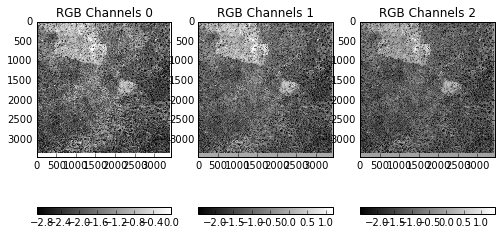

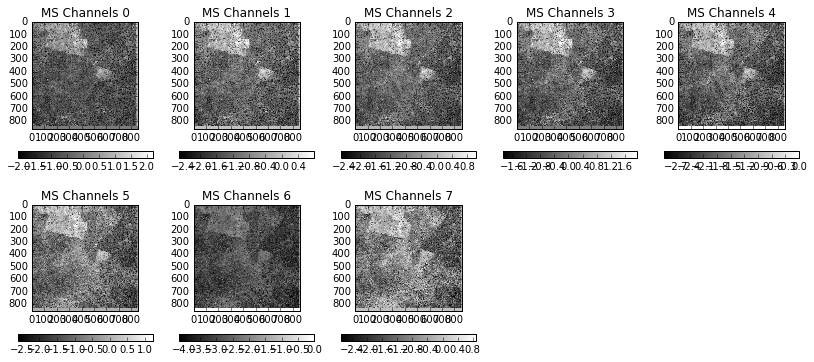

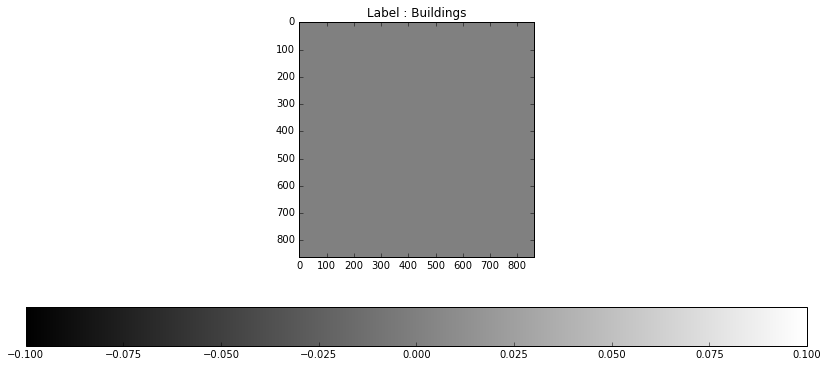

In [8]:
batch_size = 1
for [X_rgb, X_ms], Y in generate_images(train_ids, batch_size):
    print X_rgb.shape, X_ms.shape, Y.shape
    print X_rgb.min(), X_rgb.max(), X_ms.min(), X_ms.max(), Y.min(), Y.max()
    
    for i in range(batch_size):
        
        plt.figure(figsize=(14, 6))        
        m = 5 
        n = int(X_rgb.shape[1] * 1.0 / m + 1.0)
        for j in range(X_rgb.shape[1]):
            plt.subplot(n,m,j+1)
            display_img_1b(X_rgb[i,j,:,:])
            plt.title("RGB Channels %i" % j)

        plt.figure(figsize=(14, 6))        
        m = 5 
        n = int(X_ms.shape[1] * 1.0 / m + 1.0)
        for j in range(X_ms.shape[1]):
            plt.subplot(n,m,j+1)
            display_img_1b(X_ms[i,j,:,:])
            plt.title("MS Channels %i" % j)            
            
        plt.figure(figsize=(14, 6))    
        display_img_1b(Y[i,0,:,:])
        plt.title("Label : %s" % LABELS[labels[0]])

    break

In [9]:
from keras.optimizers import Adam, Nadam, SGD, Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from metrics import jaccard_coef, jaccard_coef_int

from cosmiqnet import cosmiqnet_zero

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5103)


In [10]:
model = cosmiqnet_zero(img_rgb_shape, img_ms_shape, n_layers=5, n_filters=64, size=3, beta=0.7)
weights_filename = os.path.join("weights", "cosmiqnet_%i_rgb_ms.h5" % (labels[0]))

Exception: ('Not a Keras tensor:', Elemwise{add,no_inplace}.0)

In [ ]:
model.summary()

In [ ]:
if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint(weights_filename, monitor='loss', save_best_only=True)

In [ ]:
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'recall', 'precision'])

In [ ]:
# foo = lambda x: max(x // 10, min(batch_size * 10, x))

batch_size = 4
samples_per_epoch = 1024
nb_val_samples = 256 + 128


print batch_size, samples_per_epoch, nb_val_samples
try:
    history = model.fit_generator(
        generate_images(train_ids, batch_size),
        samples_per_epoch=samples_per_epoch, 
        nb_epoch=50,
        validation_data=generate_images(val_ids, batch_size),
        nb_val_samples=nb_val_samples,
        callbacks=[model_checkpoint],
        verbose=1
    )
except KeyboardInterrupt:    
    model.save_weights(weights_filename)
